# Setup

In [1]:
import numpy as np
import pickle

from cobaya.run import run
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt

%matplotlib inline

gdplot = gdplt.get_subplot_plotter(width_inch=15)

In [2]:
jobFile = '/scratch/users/stevensonb/results/DALI_ng.pkl'
experiment = 0
spectrum = 'unlensed'
priorWidth = 5
useDali = True

fixedParams = {} # use {k:v}, values not found in fid will be ignored
removeParams = ['N_eff', 'mnu']

## Functions

In [3]:
latex_trans = {
    'omega_c_h2':r'\Omega_\mathrm{cdm}h^2', 
    'omega_b_h2':r'\Omega_\mathrm{b}h^2', 
    'N_eff':r'N_\mathrm{eff}', 
    'A_s':r'A_\mathrm{s}', 
    'n_s':r'n_\mathrm{s}', 
    'theta_s':r'\theta_\mathrm{s}',
    'tau':r'\tau',
    'mnu':r'm_\mathrm{\nu}'
}

def get_data(file=jobFile, fixed_params=fixedParams, remove_params=removeParams, experiment=experiment, spectrum=spectrum, prior_width=priorWidth):
    params = {}
    with open(file, 'rb') as f:
        data = pickle.load(f)

    fid = data['cosmoFid']
    fisher = data['fisherGaussian'][experiment][spectrum]
    if remove_params:
        for k in remove_params:
            i = list(fid.keys()).index(k)
            fid.pop(k)
            fisher = np.delete(np.delete(fisher, i, 0), i, 1)

    inv = np.linalg.inv(fisher)
    errors = np.sqrt(np.diag(inv))
    widths = prior_width * errors

    for i, (k, v) in enumerate(fid.items()):
        if k not in fixed_params:
            val = {'ref': v, 'latex': latex_trans.get(k, k), 'prior': {'min': v-widths[i], 'max':v+widths[i]}}
            params.update({k: val})
        else:
            params.update({k: {'value': fixed_params[k], 'latex': latex_trans.get(k, k)}})
    
    return params, fid, 0.5*(inv+inv.T)

def get_model(use_dali=useDali, file=jobFile, fixed_params=fixedParams, remove_params=removeParams, experiment=experiment, spectrum=spectrum, prior_width=priorWidth):
    params, cosmoFid, cov = get_data(file, fixed_params, remove_params, experiment, spectrum, prior_width)

    model = {
        'likelihood': {
            'dali': { 
                'python_path': 'likelihoods/dali',
                'use_dali': use_dali,
                'file': file,
                'remove': removeParams,
                'experiment': experiment,
                'spectrum': spectrum
            }
        },
        'params': params,
        'sampler': {
            'mcmc': {
                'covmat_params': list(params.keys()),
                'covmat': cov,
                'oversample_power': 0.4,
                'proposal_scale': 1.9,
                'Rminus1_stop': 0.01,
                'Rminus1_cl_stop': 0.2, 
                # 'max_tries': 100000
            }
        }
    }
    return model

In [4]:
# Setup a default model
defaultModel = get_model()
defaultParams, defaultFid, defaultCov = get_data(jobFile)
updatedDefault, samplerDefault = run(defaultModel)
gdsDefault = MCSamplesFromCobaya(updatedDefault, samplerDefault.products()["sample"], name_tag='Default')

# import pprint
# pp = pprint.PrettyPrinter(indent = 2)
# pp.pprint(defaultModel)

[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {dali: 11100.0}
[mcmc] Covariance matrix loaded for params ['omega_c_h2', 'omega_b_h2', 'A_s', 'n_s', 'tau', 'theta_s']
[mcmc] All parameters' covariance loaded from given covmat.
[mcmc] Initial point: omega_c_h2:0.1197, omega_b_h2:0.0222, A_s:2.196e-09, n_s:0.9655, tau:0.078, theta_s:0.010409
[mcmc] Sampling!
[mcmc] Progress @ 2021-10-06 11:57:12 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.348
[mcmc]  - Convergence of means: R-1 = 0.722328 after 192 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 480 samples accepted.
[mcmc]  - Acceptance rate: 0.393
[mcmc]  - Convergence of means: R-1 = 0.389784 after 384 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence

# Analysis

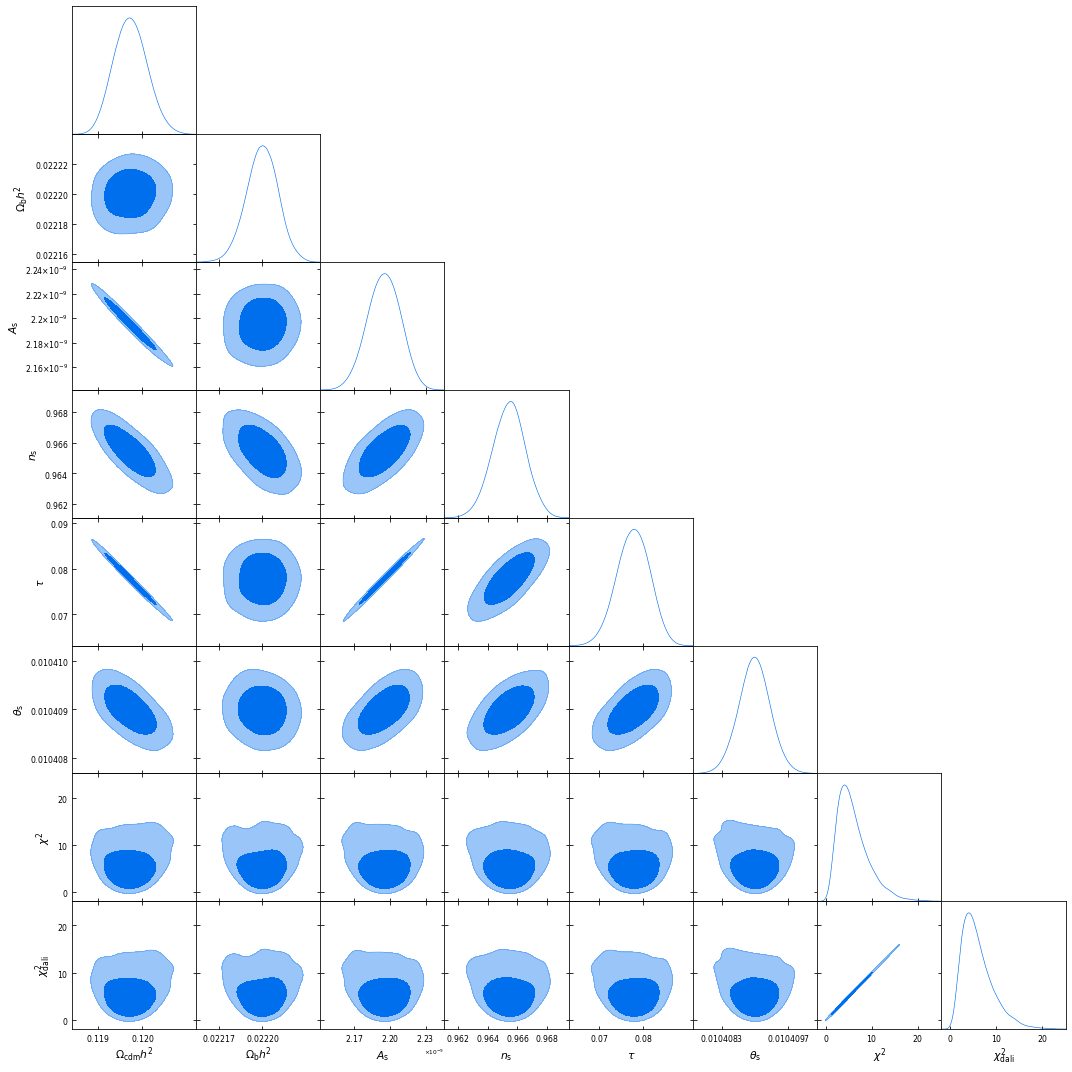

In [5]:
gdplot.triangle_plot(gdsDefault, filled=True)

In [6]:
import copy

updatedDali, samplerDali = run(get_model(use_dali=True))
gdsDali = MCSamplesFromCobaya(updatedDali, samplerDali.products()["sample"], name_tag='Dali')

updatedFisher, samplerFisher = run(get_model(use_dali=False))
gdsFisher = MCSamplesFromCobaya(updatedFisher, samplerFisher.products()["sample"], name_tag='Fisher')

[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {dali: 3900.0}
[mcmc] Covariance matrix loaded for params ['omega_c_h2', 'omega_b_h2', 'A_s', 'n_s', 'tau', 'theta_s']
[mcmc] All parameters' covariance loaded from given covmat.
[mcmc] Initial point: omega_c_h2:0.1197, omega_b_h2:0.0222, A_s:2.196e-09, n_s:0.9655, tau:0.078, theta_s:0.010409
[mcmc] Sampling!
[mcmc] Progress @ 2021-10-06 11:57:42 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.374
[mcmc]  - Convergence of means: R-1 = 0.837933 after 192 accepted steps
[blockedproposer] *ERROR* The given covmat is not a positive-definite, symmetric square matrix.
[mcmc] Learn + convergence test @ 480 samples accepted.
[mcmc]  - Acceptance rate: 0.372
[mcmc]  - Convergence of means: R-1 = 0.519783 after 384 accepted steps
[mcmc]  - Updated covariance matrix o

[root] *WARNING* Parameters are 100% correlated: chi2, chi2__dali


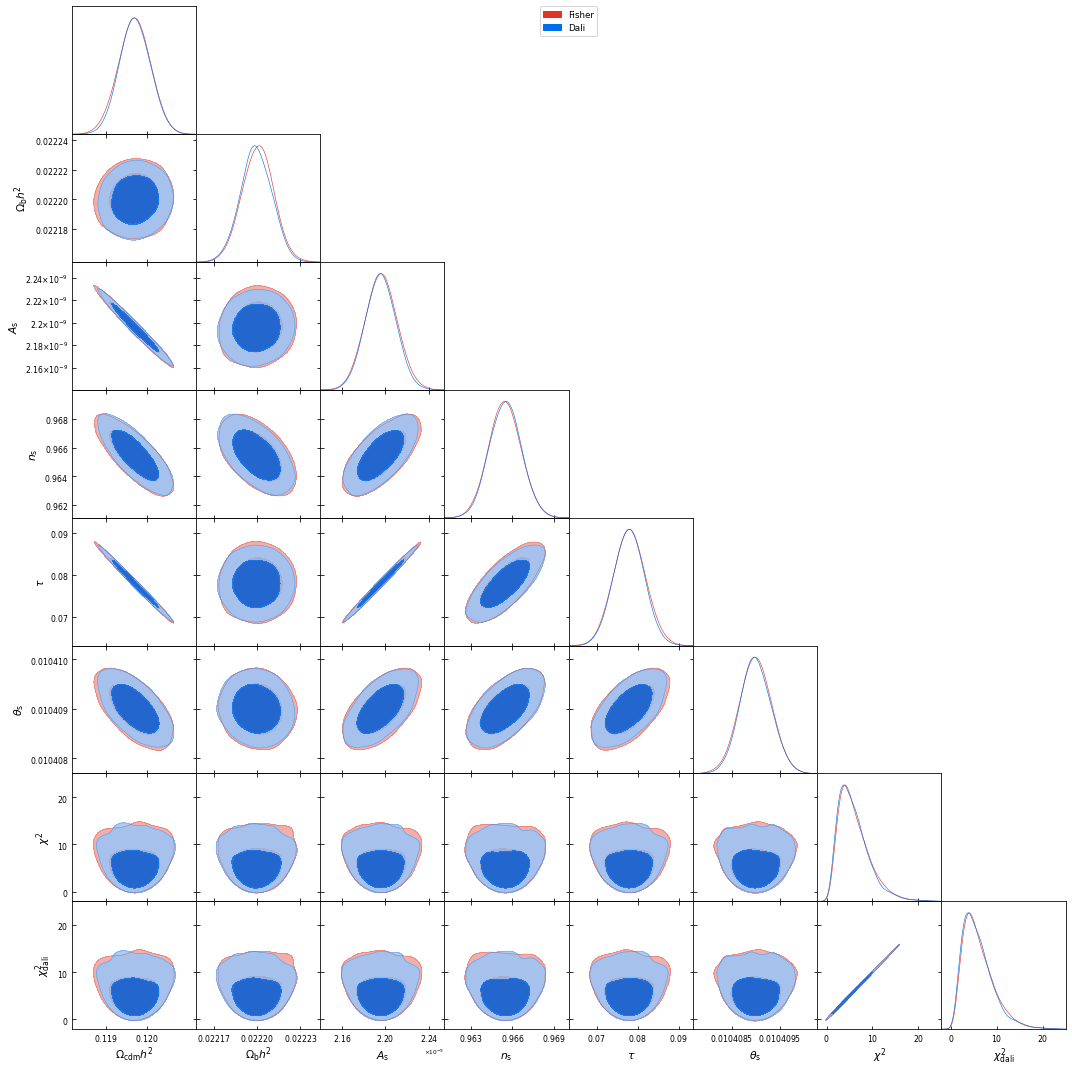

In [7]:
gdplot.triangle_plot([gdsFisher, gdsDali], filled=True)
# gdplot.triangle_plot(gdsDali, filled=True)
# gdplot.triangle_plot(gdsFisher, filled=True)

In [19]:
aVar = np.diag(defaultCov)
fVar = gdsFisher.getVars()[:-2]
dVar = gdsDali.getVars()[:-2]

print("dali - fisher:", dVar - fVar)
print("(dali - fisher)/fisher:", (dVar - fVar)/fVar)
print("aVar - fVar", aVar - fVar) 
print("(aVar - fVar)/fVar:", (aVar - fVar)/fVar)

dali - fisher: [-1.36647369e-08 -2.05561987e-12 -2.16968754e-23 -1.18992389e-08
 -1.46170008e-06 -6.28669388e-15]
(dali - fisher)/fisher: [-0.08604997 -0.0169834  -0.09876535 -0.00894481 -0.09411524 -0.05610148]
aVar - fVar [-2.75553263e-09  1.03000426e-12 -4.54908696e-24  2.63712626e-08
 -3.00617444e-07 -1.92429143e-15]
(aVar - fVar)/fVar: [-0.01735222  0.00850983 -0.02070769  0.01982361 -0.01935601 -0.01717208]


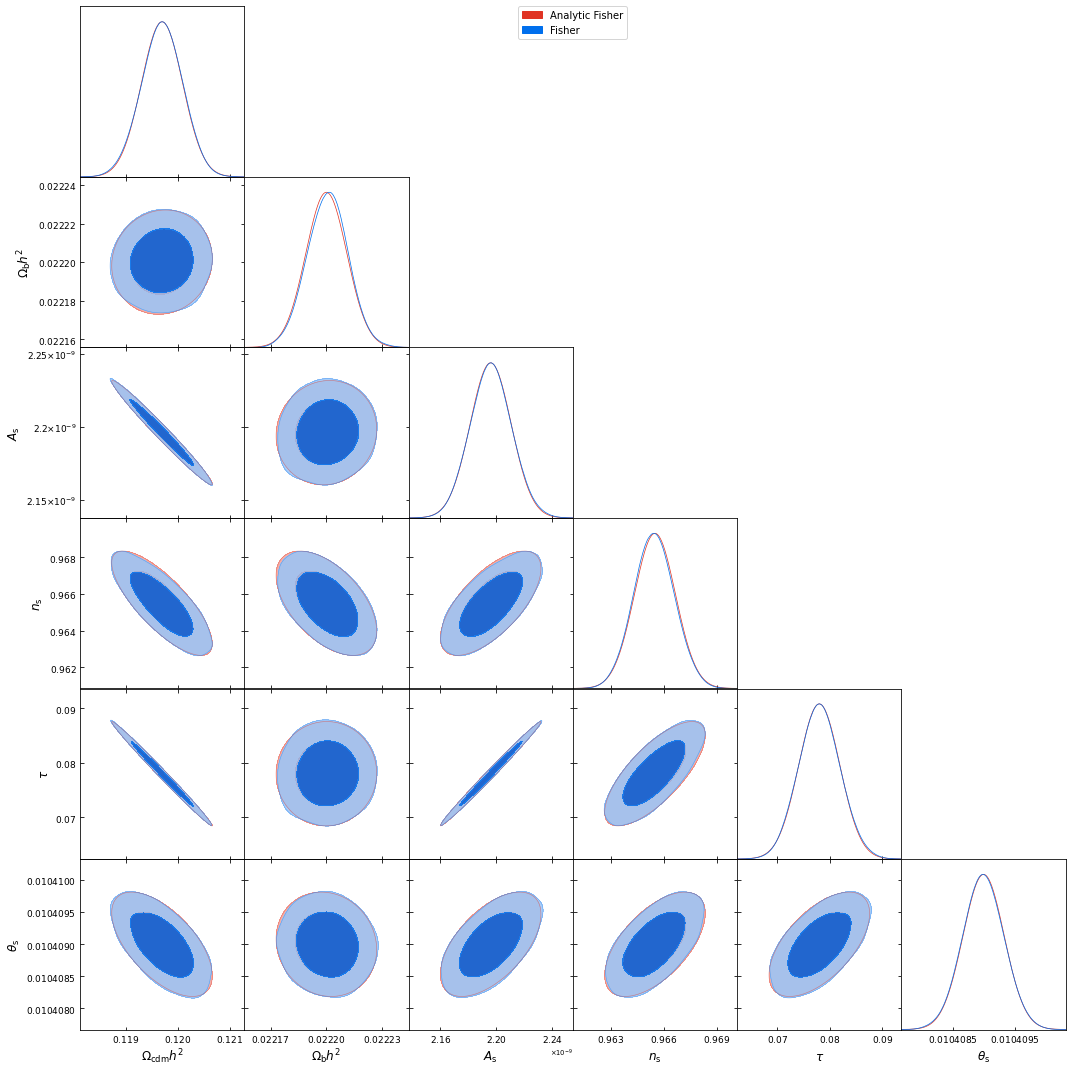

In [9]:
from getdist.gaussian_mixtures import GaussianND
gauss=GaussianND(list(defaultFid.values()), defaultCov, names=list(gdsFisher.getParamNames().list())[:-2], labels=list(gdsFisher.getParamNames().labels())[:-2], label='Analytic Fisher')
gdplot.triangle_plot([gauss, gdsFisher],filled=True)

In [10]:
sample_data = []
for width in range(3, 11, 1):
    m = get_model(prior_width=width)
    uf, sf = run(m)
    sample_data.append(MCSamplesFromCobaya(uf, sf.products()['sample'], name_tag='Dali - Width: %s'%width))

[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {dali: 4750.0}
[mcmc] Covariance matrix loaded for params ['omega_c_h2', 'omega_b_h2', 'A_s', 'n_s', 'tau', 'theta_s']
[mcmc] All parameters' covariance loaded from given covmat.
[mcmc] Initial point: omega_c_h2:0.1197, omega_b_h2:0.0222, A_s:2.196e-09, n_s:0.9655, tau:0.078, theta_s:0.010409
[mcmc] Sampling!
[mcmc] Progress @ 2021-10-06 11:58:44 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.337
[mcmc]  - Convergence of means: R-1 = 0.732552 after 192 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 480 samples accepted.
[mcmc]  - Acceptance rate: 0.373
[mcmc]  - Convergence of means: R-1 = 0.292048 after 384 accepted steps
[blockedproposer] *ERROR* The given covmat is not a positive-definite, symmetric

[root] *WARNING* Parameters are 100% correlated: chi2, chi2__dali
[root] *WARNING* Parameters are 100% correlated: chi2, chi2__dali
[root] *WARNING* Parameters are 100% correlated: chi2, chi2__dali
[root] *WARNING* Parameters are 100% correlated: chi2, chi2__dali


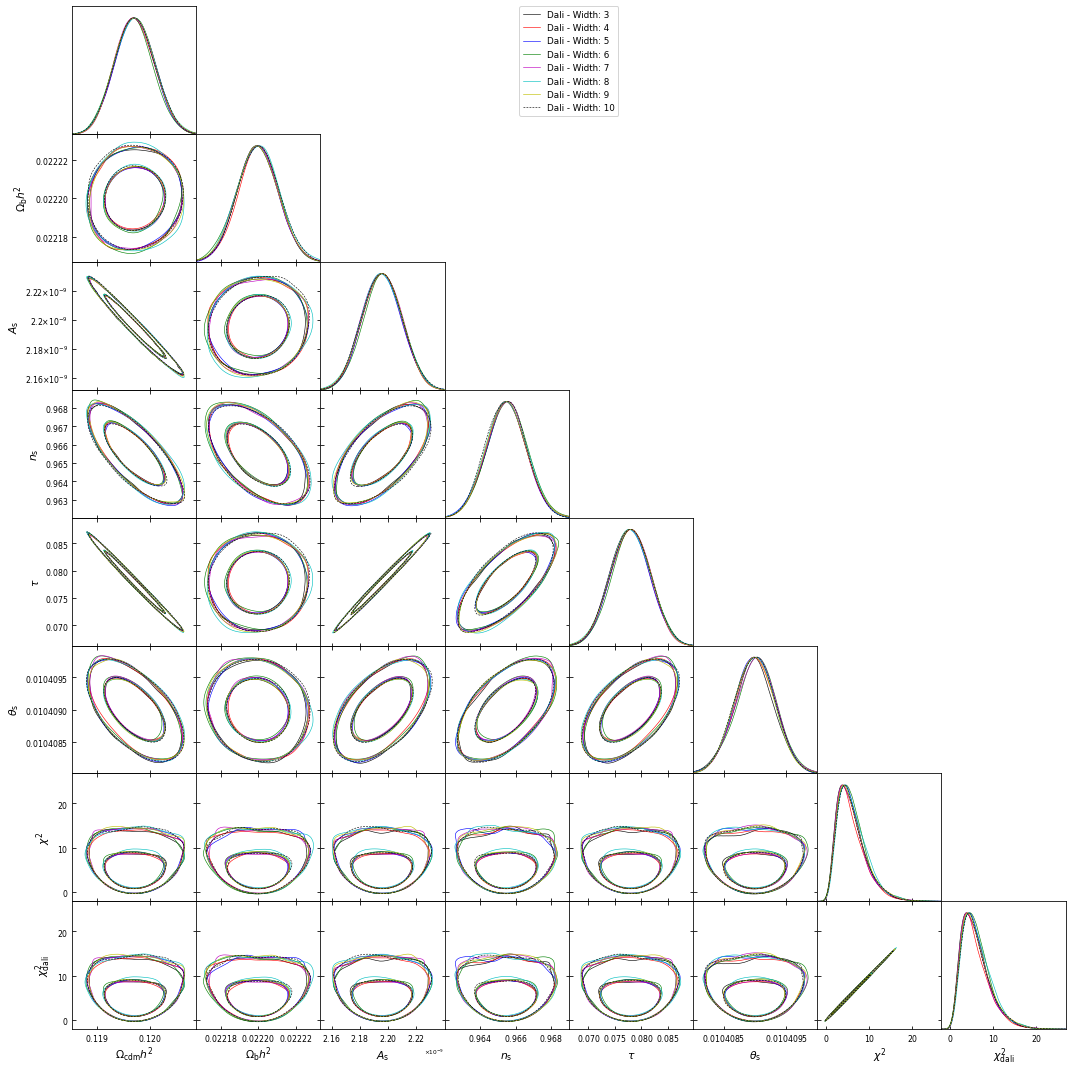

In [11]:
gdplot.triangle_plot(sample_data, filled=False)
# for v in sample_data: gdplot.triangle_plot(v, filled=True)

In [15]:
exp_data = []
for exp in range(1, 11):
   m = get_model(experiment=exp)
   uf, sf = run(m)
   exp_data.append(MCSamplesFromCobaya(uf, sf.products()['sample'], name_tag='Dali - Experiment: %i'%exp))

[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {dali: 4220.0}
[mcmc] Covariance matrix loaded for params ['omega_c_h2', 'omega_b_h2', 'A_s', 'n_s', 'tau', 'theta_s']
[mcmc] All parameters' covariance loaded from given covmat.
[mcmc] Initial point: omega_c_h2:0.1197, omega_b_h2:0.0222, A_s:2.196e-09, n_s:0.9655, tau:0.078, theta_s:0.010409
[mcmc] Sampling!
[mcmc] Progress @ 2021-10-06 13:35:26 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.336
[mcmc]  - Convergence of means: R-1 = 0.394694 after 192 accepted steps
[blockedproposer] *ERROR* The given covmat is not a positive-definite, symmetric square matrix.
[mcmc] Learn + convergence test @ 480 samples accepted.
[mcmc]  - Acceptance rate: 0.353
[mcmc]  - Convergence of means: R-1 = 0.112475 after 384 accepted steps
[mcmc]  - Updated covariance matrix o

[root] *WARNING* Parameters are 100% correlated: chi2, chi2__dali
[root] *WARNING* Parameters are 100% correlated: chi2, chi2__dali
[root] *WARNING* Parameters are 100% correlated: chi2, chi2__dali
[root] *WARNING* Parameters are 100% correlated: chi2, chi2__dali
[root] *WARNING* Parameters are 100% correlated: chi2, chi2__dali
[root] *WARNING* Parameters are 100% correlated: chi2, chi2__dali
[root] *WARNING* Parameters are 100% correlated: chi2, chi2__dali


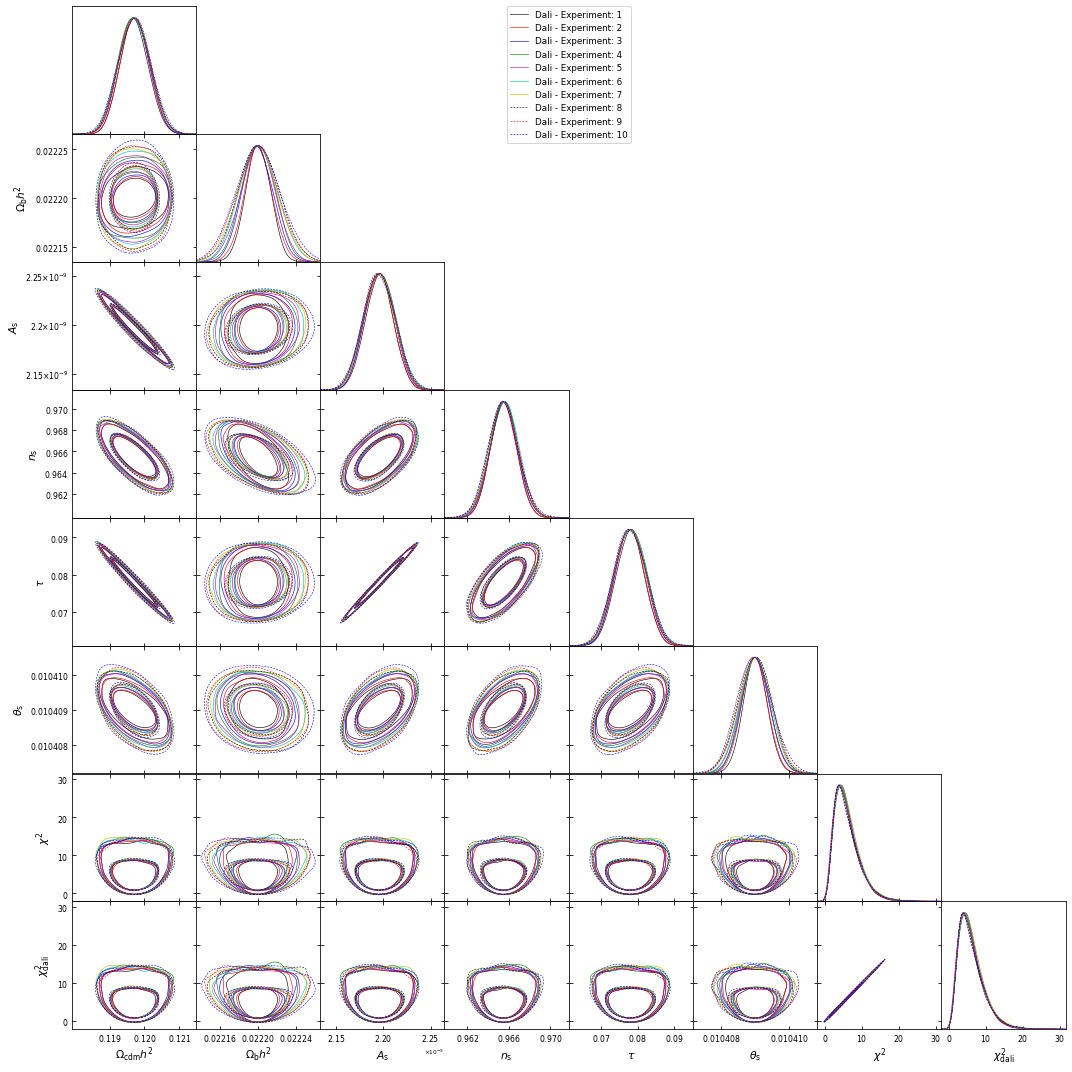

In [17]:
gdplot.triangle_plot(exp_data, filled=False)
# for v in exp_data: gdplot.triangle_plot(v, filled=True) 

In [18]:
spect_data = []
for spectrum in ['unlensed', 'lensed', 'delensed', 'lensing']:
    m = get_model(spectrum=spectrum)
    uf, sf = run(m)
    spect_data.append(MCSamplesFromCobaya(uf, sf.products()['sample'], name_tag='Dali - Spectrum: %s'%spectrum))

[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {dali: 11300.0}
[mcmc] Covariance matrix loaded for params ['omega_c_h2', 'omega_b_h2', 'A_s', 'n_s', 'tau', 'theta_s']
[mcmc] All parameters' covariance loaded from given covmat.
[mcmc] Initial point: omega_c_h2:0.1197, omega_b_h2:0.0222, A_s:2.196e-09, n_s:0.9655, tau:0.078, theta_s:0.010409
[mcmc] Sampling!
[mcmc] Progress @ 2021-10-06 14:07:09 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.347
[mcmc]  - Convergence of means: R-1 = 0.876506 after 192 accepted steps
[blockedproposer] *ERROR* The given covmat is not a positive-definite, symmetric square matrix.
[mcmc] Learn + convergence test @ 480 samples accepted.
[mcmc]  - Acceptance rate: 0.381
[mcmc]  - Convergence of means: R-1 = 0.435445 after 384 accepted steps
[mcmc]  - Updated covariance matrix 

LoggedError: The covariance matrix passed is not a positive-definite, symmetric square matrix.

In [ ]:
gdplot.triangle_plot(spect_data, filled=False)
# for v in spect_data: gdplot.triangle_plot(v, filled=True)